# 스팸 메일 분류하기(Spam Detection)

---
캐글에서 제공하는 스팸 메일 데이터를 학습시켜 스팸 메일 분류기를 구현해보겠습니다.

# 1. 스팸 메일 데이터에 대한 이해

다운로드 링크 : https://www.kaggle.com/uciml/sms-spam-collection-dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from sklearn.model_selection import train_test_split

import torch
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

다운로드 받은 spam.csv 파일을 데이터프레임으로 로드하고 총 샘플의 수를 확인해봅시다.

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv",
                           filename="spam.csv")

('spam.csv', <http.client.HTTPMessage at 0x7f446533cee0>)

In [3]:
data = pd.read_csv('spam.csv', encoding='latin1')
print(f'총 샘플 수 :{len(data)}')

총 샘플 수 :5572


총 5,572개의 샘플이 존재합니다. 상위 5개의 샘플만 출력해봅시다.

In [4]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


스팸 메일 데이터 중에서 5개의 행만 출력해보았습니다.   
이 데이터에는 총 5개의 열이 있는데, 여기서 Unnamed라는 이름의 3개의 열은 텍스트 분류를 할 때 불필요한 열입니다.  

v1열은 해당 메일이 스팸인지 아닌지를 나타내는 레이블에 해당되는 열입니다.  
- ham은 정상 메일을 의미하고, spam은 스팸 메일을 의미합니다. 

v2열은 메일의 본문을 담고있습니다.

레이블과 메일 내용이 담긴 v1열과 v2열만 필요하므로, Unnamed: 2, Unnamed: 3, Unnamed: 4 열은 삭제합니다.  
또한, v1열에 있는 ham과 spam 레이블을 각각 숫자 0과 1로 바꾸겠습니다.  
다시 data에서 5개의 행만 출력해보겠습니다.

In [5]:
data = data[['v1', 'v2']]
data['v1'] = data['v1'].replace(['ham', 'spam'], [0, 1])
data.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


불필요한 열이 제거되고 v1열의 값이 숫자로 변환된 것을 확인할 수 있습니다.  
해당 데이터프레임의 정보를 확인해보겠습니다.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


v1열은 정수형, v2열은 문자열 데이터를 갖고 있습니다.  
Null 값을 가진 샘플이 있는지 isnull().values.any()로 확인합니다.

In [7]:
print(f'결손값 개수\n{data.isnull().sum()}')

결손값 개수
v1    0
v2    0
dtype: int64


별도의 Null 값은 없음을 의미합니다.  

Null 값이 없다면 데이터에 중복이 있는지 확인해보겠습니다.

In [8]:
print(f'v2열의 유니크한 값 : {data["v2"].nunique()}')

v2열의 유니크한 값 : 5169


총 5,572개의 샘플이 존재하는데 v2열에서 중복을 제거한 샘플의 개수가 5,169개라는 것은 403개의 중복 샘플이 존재한다는 의미입니다.  

중복 샘플을 제거하고 전체 샘플 수를 확인합니다.

In [9]:
data.drop_duplicates(subset=['v2'], inplace=True)
print(f'총 샘플 수 :{len(data)}')

총 샘플 수 :5169


총 샘플의 수가 5,572개에서 5,169개로 줄었습니다.  

레이블 값의 분포를 시각화합니다.

<AxesSubplot:>

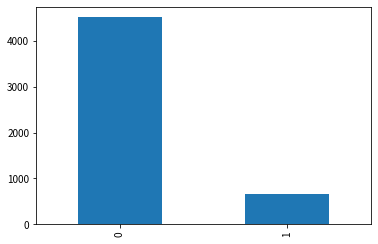

In [10]:
data['v1'].value_counts().plot(kind='bar')

레이블이 대부분 0에 편중되어있는데, 이는 스팸 메일 데이터의 대부분의 메일이 정상 메일임을 의미합니다.  
정확한 수치를 파악해보겠습니다.

In [11]:
print('정상 메일과 스팸 메일의 개수')
print(data.groupby('v1').size().reset_index(name='count'))

정상 메일과 스팸 메일의 개수
   v1  count
0   0   4516
1   1    653


레이블 0은 총 4,516개가 존재하고 1은 653개가 존재합니다.  
이를 %로 환산합니다.

In [12]:
vc = data["v1"].value_counts()
print(f'정상 메일의 비율 = {round(vc[0]/len(data) * 100, 3)}%')
print(f'스팸 메일의 비율 = {round(vc[1]/len(data) * 100, 3)}%')

정상 메일의 비율 = 87.367%
스팸 메일의 비율 = 12.633%


v2열과 v1열을 X_data, y_data로 저장합니다.

In [13]:
X_data = data['v2']
y_data = data['v1']
print('메일의 개수: {}'.format(len(X_data)))
print('라벨의 개수: {}'.format(len(y_data)))

메일의 개수: 5169
라벨의 개수: 5169


훈련 데이터와 테스트 데이터를 분리합니다. 
- 주의할 점은 현재 레이블이 굉장히 불균형합니다. 
- 다시 말해 정상 메일 샘플(87%, 4516개)에 비해서 스팸 메일 샘플(12%, 653개)이 굉장히 적습니다. 
- 만약, 훈련 데이터와 테스트 데이터를 분리하는 과정에서 우연히 대부분의 스팸 메일 샘플이 테스트 데이터에 포함되고 훈련 데이터에는 대부분 정상 메일 샘플만 포함되게 된다면 어떻게 될까요? 
  - 학습 과정에서 모델은 스팸 메일 샘플을 거의 관측하지 못해서 모델의 성능이 저하될 것입니다.


이렇게 레이블이 불균형한 경우에는 데이터를 나눌 때에도 훈련 데이터와 테스트 데이터에 각 레이블의 분포가 고르게 분포되도록 하는 것이 중요할 수 있습니다. 
- 사이킷 런의 train_test_split에 stratify의 인자로서 레이블 데이터를 기재하면 훈련 데이터와 테스트 데이터를 분리할 때 레이블의 분포가 고르게 분포하도록 합니다. 
- test_size에 0.2를 기재하여 훈련 데이터와 테스트 데이터를 8:2 비율로 분리합니다.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0, stratify=y_data)

훈련 데이터와 테스트 데이터가 분리되었습니다.  
레이블이 고르게 분포되었는지 확인합니다.

In [15]:
ytrain_vc = y_train.value_counts()

print('--------훈련 데이터의 비율-----------')
print(f'정상 메일의 비율 = {round(ytrain_vc[0]/len(y_train) * 100, 3)}%')
print(f'스팸 메일의 비율 = {round(ytrain_vc[1]/len(y_train) * 100, 3)}%')

--------훈련 데이터의 비율-----------
정상 메일의 비율 = 87.376%
스팸 메일의 비율 = 12.624%


In [16]:
ytest_vc = y_test.value_counts()

print('--------테스트 데이터의 비율-----------')
print(f'정상 메일의 비율 = {round(ytest_vc[0]/len(y_test) * 100, 3)}%')
print(f'스팸 메일의 비율 = {round(ytest_vc[1]/len(y_test) * 100, 3)}%')

--------테스트 데이터의 비율-----------
정상 메일의 비율 = 87.331%
스팸 메일의 비율 = 12.669%


훈련 데이터와 테스트 데이터 모두 정상 메일은 87%, 스팸 메일은 12%가 존재합니다.  

토크나이저를 통해 훈련 데이터에 대해서 토큰화와 정수 인코딩 과정을 수행합니다.  
X_train_encoded에는 X_train의 각 단어들이 맵핑되는 정수로 인코딩되어 저장됩니다.  
- 5개의 메일만 출력해서 확인해보겠습니다.

In [17]:
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(X_train), specials=["<unk>", "<pad>"])
vocab.set_default_index(vocab["<unk>"])

In [18]:
text_pipeline = lambda x: vocab(tokenizer(x))

In [19]:
X_train_encoded = [torch.LongTensor(text_pipeline(text)) for text in X_train]
print(X_train_encoded[:5])

[tensor([115,   7,   3,  28,   6,  41, 226,   4,  25,  48,   2]), tensor([   3,   71,   14,  427,   25,   10,  149,    5, 2553]), tensor([ 171,  193,   19,   20,  107,  101,    2,   55,   15,   49, 7774,  247,
          14,    2,   13,  103,   12,   91, 1327,   10, 5525,   13, 2488,    2,
          17,  683,  308,   27,   34,  469,    7,  740, 1060,  217,  141,  209,
         891, 2513,   33,    3,  156,   82,    5,  121,   89,   50,    5,  142,
          17,  891,  201,    2,  132, 1716,    2]), tensor([   3, 1217,   20,  114,  318]), tensor([262, 617, 875, 541, 615,  31,  33,  98,  16,  55,  12, 260,  43,  12,
         28,  76, 958, 489])]


각 메일이 정수 인코딩이 되었습니다.  
- 각 정수가 어떤 단어에 부여되었는지 확인해봅시다.

In [20]:
word_to_index = vocab.get_stoi()
print(word_to_index)

{'ì¬n': 8046, 'åôrents': 8045, 'åômorrow': 8044, 'åòit': 8043, 'åè10': 8041, 'å£79': 8040, 'å£75': 8038, 'å£600': 8036, 'å£50-å£500': 8033, 'å£48': 8030, 'å£250k': 8028, 'å£1250': 8026, 'å£12': 8024, 'å£1/minmobsmorelkpobox177hp51fl': 8022, '\x8eö´\x89ó_': 8021, '\x89û_thanks': 8018, '~': 8017, 'zyada': 8016, 'zouk': 8015, 'zhong': 8013, 'zebra': 8011, 'zealand': 8010, 'zaher': 8009, 'yoville': 8001, 'youåõre': 8000, 'you\x89û÷ll': 7999, 'youwanna': 7998, 'yourinclusive': 7996, 'young': 7993, 'youdoing': 7991, 'yo-here': 7988, 'ymca': 7987, 'yijue@hotmail': 7986, 'yes-910': 7982, 'yes-762': 7981, 'yes-434': 7980, 'yeovil': 7979, 'yen': 7978, 'yelow': 7977, 'yelling': 7975, 'yeesh': 7974, 'yaxxx': 7973, 'yaxx': 7972, 'yavnt': 7971, 'yards': 7970, 'yalrigu': 7968, 'yah': 7967, 'xxxxxxxx': 7965, 'xxxxxxx\\': 7964, 'xxuk': 7962, 'xt': 7960, 'xclusive@clubsaisai': 7959, 'xafter': 7957, 'x29': 7956, 'wth': 7950, 'wtc': 7949, 'wt': 7948, 'wrnog': 7945, 'wrld': 7944, 'wrks': 7943, 'wrking': 79

In [21]:
print(vocab.get_itos())

['<unk>', '<pad>', '.', 'i', 'you', 'to', "'", ',', '?', 'a', 'the', '!', 'u', 'and', 'in', 'is', 'me', 'my', 'it', 'for', 'your', 'that', 'of', 'have', 's', 'on', 'call', 'are', 'can', '2', ')', 'now', 'but', 'so', 'not', 'm', 'or', 'we', 'at', 'do', 'get', 't', 'be', 'if', 'will', 'just', 'with', 'no', 'this', 'ur', 'how', 'up', '&lt', 'what', 'go', 'when', '4', 'from', 'ok', '#&gt', 'know', 'out', 'all', 'free', 'like', 'll', 'then', 'he', 'there', 'got', 'good', 'am', 'was', 'come', 'time', 'its', 'love', 'want', 'only', 'day', 'text', '-', 'need', 'going', 'lor', 'one', 'as', 'send', 'home', 'about', 'back', 'still', 'k', 'she', 'see', 'don', 'by', 'da', 'txt', 'any', 'stop', 'today', 'dont', 'r', 'tell', 'please', 'our', 'reply', 'take', 'hi', 'ì_', 'n', 'they', 'her', 'new', 'sorry', 'some', 'did', 'mobile', 'oh', 'him', 'think', 'night', 'hey', 're', 'been', 'phone', 'great', 'here', 'much', 'too', 'hope', 'later', 'week', 'had', 'more', 'pls', 'where', 'wat', 'well', 'should',

무수히 많은 단어가 출력되므로 출력 결과는 중간에 생략했습니다. 
- 위에서 부여된 각 정수는 각 단어의 빈도수가 높을 수록 낮은 정수가 부여됩니다. 
- 다시 말해, 단어 .는 현재 전체 훈련 데이터에서 빈도수가 가장 높은 단어입니다.

등장 빈도가 지나치게 낮은 단어들은 자연어 처리에서 제외하고 싶다면 Vocab 생성 시에 단어 집합의 크기를 제한할 수 있습니다.  
- 가령, 아래의 코드로 등장 빈도가 1회인 단어들을 제외할 수 있을 겁니다.

```python
build_vocab_from_iterator(min_fred=2)
```

하지만 이번 실습에서는 별도로 단어 집합의 크기를 제한하진 않겠습니다.  
- 단어 집합의 크기를 vocab_size에 저장하겠습니다. 

In [22]:
vocab_size = len(word_to_index) + 1
print('단어 집합의 크기: {}'.format((vocab_size)))

단어 집합의 크기: 8048


단어 집합의 크기는 8,048입니다. 

전체 데이터에서 가장 길이가 긴 메일과 전체 메일 데이터의 길이 분포를 확인합니다.

메일의 최대 길이 : 212
메일의 평균 길이 : 19.282467


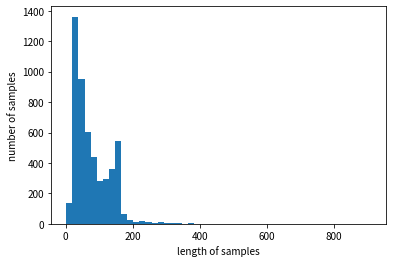

In [23]:
print('메일의 최대 길이 : %d' % max(len(sample) for sample in X_train_encoded))
print('메일의 평균 길이 : %f' % (sum(map(len, X_train_encoded))/len(X_train_encoded)))
plt.hist([len(sample) for sample in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

가장 긴 메일의 길이는 212이며, 전체 데이터의 길이 분포는 대체적으로 약 50이하의 길이를 가집니다.

In [24]:
from torch.nn.utils.rnn import pad_sequence

In [25]:
X_train_padded = pad_sequence(X_train_encoded, batch_first=True, padding_value=vocab(['<pad>'])[0])
print("훈련 데이터의 크기(shape):", X_train_padded.shape)

훈련 데이터의 크기(shape): torch.Size([4135, 212])


pad_sequence는 4,135개의 X_train_encoded의 길이를 전부 212로 바꿉니다. 
- 212보다 길이가 짧은 메일 샘플은 전부 숫자 1이 패딩되어 212의 길이를 가집니다.
- X_train_encoded 데이터는 4,135 × 212의 크기를 갖게 됩니다. 

## 2. 데이터로더 생성

In [26]:
from torch.utils.data import Dataset, DataLoader
from torchtext.data.functional import to_map_style_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
class MyDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __len__(self):
        assert len(self.X_data) == len(self.y_data)
        return len(self.X_data)
    
    def __getitem__(self, idx):
        x = self.X_data[idx]
        y = self.y_data[idx]
        return x, y

In [28]:
def collate_batch(batch):
    text_list, label_list = list(zip(*batch))
    text_list = torch.stack(text_list)
    label_list = torch.tensor(label_list, dtype=torch.int64)

    return text_list.to(device), label_list.to(device)

하이퍼파라미터인 배치 크기는 32이다. 

In [29]:
BATCH_SIZE = 64 # batch size for training
train_dataset = MyDataset(X_train_padded, y_train.values)
dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

모델을 설계해보겠습니다.

## 3. RNN으로 스팸 메일 분류하기

하이퍼파라미터인 임베딩 벡터의 차원은 32, 은닉 상태의 크기는 32입니다.  

모델은 다 대 일 구조의 RNN을 사용합니다. 
- 해당 모델은 마지막 시점에서 두 개의 선택지 중 하나를 예측하는 이진 분류 문제를 수행하는 모델입니다. 

In [30]:
import torch.nn as nn
from torch.optim import SGD, Adam

In [31]:
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(SimpleRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=vocab(['<pad>'])[0])
        self.rnn = nn.RNN(embedding_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, 2)
        
    def forward(self, x):
        out = self.embedding(x)
        out, h = self.rnn(out)
        out = self.linear(h)
        return out

In [32]:
model = SimpleRNN(vocab_size, 32, 32)
optimizer = Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

10 에폭만큼 학습을 수행한다.

In [33]:
import time

EPOCHS = 10 # epoch

model.train()
total_acc, total_count = 0, 0
log_interval = 10
start_time = time.time()

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    
    for idx, (text, label) in enumerate(dataloader):
        predicted_label = model(text)[0]
        optimizer.zero_grad()
        loss = criterion(predicted_label, label)
        loss.backward()
        optimizer.step()
        
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)

        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()
            
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s'.format(epoch, time.time() - epoch_start_time))
    print('-' * 59)

| epoch   1 |    10/   65 batches | accuracy    0.884
| epoch   1 |    20/   65 batches | accuracy    0.870
| epoch   1 |    30/   65 batches | accuracy    0.878
| epoch   1 |    40/   65 batches | accuracy    0.855
| epoch   1 |    50/   65 batches | accuracy    0.878
| epoch   1 |    60/   65 batches | accuracy    0.880
-----------------------------------------------------------
| end of epoch   1 | time:  3.58s
-----------------------------------------------------------
| epoch   2 |    10/   65 batches | accuracy    0.879
| epoch   2 |    20/   65 batches | accuracy    0.870
| epoch   2 |    30/   65 batches | accuracy    0.878
| epoch   2 |    40/   65 batches | accuracy    0.855
| epoch   2 |    50/   65 batches | accuracy    0.878
| epoch   2 |    60/   65 batches | accuracy    0.880
-----------------------------------------------------------
| end of epoch   2 | time:  2.86s
-----------------------------------------------------------
| epoch   3 |    10/   65 batches | accuracy

테스트 데이터에 대해서 정확도를 확인해보겠습니다.

In [91]:
X_test_encoded = [torch.LongTensor(text_pipeline(text)) for text in X_test]
X_test_padded = pad_sequence(X_test_encoded, batch_first=True, padding_value=vocab(['<pad>'])[0])

test_dataset = MyDataset(X_test_padded, y_test.values)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_batch)

In [98]:
model.eval()
total_acc, total_count = 0, 0

with torch.no_grad():
    for idx, (text, label) in enumerate(test_dataloader):
        predicted_label = model(text)
        loss = criterion(predicted_label[0], label)
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        
accu_val = total_acc/total_count
print('test accuracy {:8.3f} '.format(accu_val))

test accuracy    0.869 


정확도가 86.9%가 나왔습니다. 

## 4. 직접 입력하여 테스트

In [99]:
text = input('문장 입력 : ')

model.eval()
with torch.no_grad():
    tokens = text_pipeline(text)
    _input = torch.LongTensor([tokens])
    _output = model(_input).view(-1)
    predicted_label = nn.Softmax(dim=0)(_output)
    label = 'ham' if predicted_label[0] > predicted_label[1] else 'spam'
    
print('-'*30)
print(f'ham : {predicted_label[0]:.3} | spam : {predicted_label[1]:.3}')
print('-'*30)
print(f'이 메일은 {label} 메일입니다.')
print('-'*30)

문장 입력 : We're not seeing any writing activity for you last week, so unless you were taking a writing break, you might have accidently logged out.
------------------------------
ham : 0.955 | spam : 0.0445
------------------------------
이 메일은 ham 메일입니다.
------------------------------


# 잘못된 모델이 만들어졌다.

해당 모델은 무조건 ham이라고 대답한다.
- 내가 생각하기에 그 이유는 데이터의 편향 때문이다. 
- 데이터가 ham이 87%, spam이 12%의 비율로 존재한다.
- 그렇기 때문에 이 모델이 무조건 ham이라고 답해도 87%의 정답률을 얻게 된다.
- 이에 대한 수정이 필요하다.